<a href="https://colab.research.google.com/github/Dabeen-Yun/RRT_analysis/blob/main/%EC%9C%A4%EB%8B%A4%EB%B9%88_%5B%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89%EC%98%88%EC%B8%A1%EB%B0%8F%EA%B3%84%ED%9A%8D%5D_RRT_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1.

In [ ]:
# 2025143782 Dabeen-Yun
import math
import numpy as np
import matplotlib.pyplot as plt
import random

def compute_path_cost(path):
  """

  Compute the  path cost (sum of Euclidean segment lengths)
  path: Path from RRT and RRT* ([[x0, y0], [x1,y1], ..., [xn,yn]])

  """

  if path is None or len(path) < 2:
    return float("inf")

  total = 0.0

  for i in range(1, len(path)):
    x0, y0 = path[i-1]
    x1, y1 = path[i]
    total += math.hypot(x1 - x0, y1 - y0)

  return total


def plot_distribution(costs, mode):
  """

  Plot cost distributions(histogram/boxplot/...)
  costs: costs of path from RRT and RRT*
  mode: one of modes (RRT or RRT*)

  """

  if len(costs) == 0:
    print("Cannot find path")
    return

  costs_np = np.array(costs, dtype=float)

  plt.figure()
  plt.hist(costs_np, bins=20)
  plt.title(f"{mode}-Path Cost Distribution (Histogram)")
  plt.xlabel("Path Cost")
  plt.ylabel("Count")
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(f"{mode}_cost_hist.png",dpi=150)

  plt.figure()
  plt.boxplot(costs_np, vert=True, showmeans=True)
  plt.title(f"{mode}-Path Cost Distribution (Boxplot)")
  plt.ylabel("Path cost")
  plt.grid(True, axis='y')
  plt.tight_layout()
  plt.savefig(f"{mode}_cost_box.png", dpi=150)


def report_summary_of_costs(costs):
  """

  Report mean/std/min/max/median
  costs: costs of path from RRT and RRT* (list[float])

  """

  if len(costs) == 0:
    return {"n":0}

  costs_np = np.array(costs, dtype=float)
  mean = float(np.mean(costs_np))
  std  = float(np.std(costs_np, ddof=1)) if len(costs_np) > 1 else 0.0
  min = float(np.min(costs_np))
  max = float(np.max(costs_np))
  med  = float(np.median(costs_np))

  summary = {
      "n": len(costs),
      "mean": mean,
      "std": std,
      "min": min,
      "max": max,
      "median": med,
  }

  return summary


def plot_optimal_path(optimal_path, mode, bg_elements=None, background_drawer=None):
  """

  Draw optimal path with obstacles

  """

  if optimal_path is None:
    print("Cannot find optimal path")
    return

  fig, ax = plt.subplots()
  if background_drawer is not None:
    background_drawer(ax, bg_elements or {})

  xs = [p[0] for p in optimal_path]
  ys = [p[1] for p in optimal_path]

  ax.plot(xs, ys, "-r", linewidth=2.5,
          label=f"best (cost={compute_path_cost(optimal_path):.2f})")
  ax.legend()
  ax.set_title(f"{mode}-Best Path")
  ax.grid(True)
  ax.set_aspect("equal", adjustable="box")
  plt.tight_layout()


def run_experiments(planner_factory, n_trials=30, seed=999, max_total_attempts=1500):
  """

  planner_factory: () -> (path, bg_elements)
  n_trials: 반복 실행 횟수

  return:
    costs: list[float]
    best_path: list[[x,y], ...]
    best_bg_elements: dict

  """

  if seed is not None:
    random.seed(seed)
    np.random.seed(seed)

  costs = []
  best_cost = float("inf")
  best_path = None
  best_bg_elements = None
  attempts = 0

  while len(costs) < n_trials and attempts < max_total_attempts:
    attempts += 1
    path, bg_elements = planner_factory()
    if path is None:
      print("NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo")
      continue

    cost = compute_path_cost(path)
    costs.append(cost)

    if cost < best_cost:
      best_cost = cost
      best_path = path
      best_bg_elements = bg_elements

  if len(costs) < n_trials:
    print(f"[WARN] num of success: {len(costs)} < {n_trials}")

  return costs, best_path, best_bg_elements


def make_planner_factory(
    start, goal, obstacle_list, rand_area,
    robot_radius=0.8, expand_dis=3.0, mode="RRT"
):
  def _factory():
    if mode == "RRT":
      rrt = RRT(
          start=start,
          goal=goal,
          rand_area=rand_area,
          obstacle_list=obstacle_list,
          robot_radius=robot_radius
       )

      path = rrt.planning(animation=False)

      bg_elements = {
          "obstacles": obstacle_list,
          "start": start,
          "goal": goal,
          "rand_area": rand_area,
          "robot_radius": robot_radius,
      }

    elif mode == "RRT*":
      rrt_star = RRTStar(
          start=start,
          goal=goal,
          rand_area=rand_area,
          obstacle_list=obstacle_list,
          expand_dis=expand_dis,
          robot_radius=robot_radius
      )

      path = rrt_star.planning(animation=False)

      bg_elements = {
        "obstacles": obstacle_list,
        "start": start,
        "goal": goal,
        "rand_area": rand_area,
        "expand_dis": expand_dis,
        "robot_radius": robot_radius,
      }
    return path, bg_elements
  return _factory

def rrt_background_drawer(ax, bg_elements):
    # obstacles
    obs = bg_elements.get("obstacles", [])
    for (ox, oy, size) in obs:
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [ox + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [oy + size * math.sin(np.deg2rad(d)) for d in deg]
        ax.plot(xl, yl)

    # start / goal
    s = bg_elements.get("start", [None, None])
    g = bg_elements.get("goal", [None, None])
    if s[0] is not None:
        ax.plot(s[0], s[1], "xr")
    if g[0] is not None:
        ax.plot(g[0], g[1], "xr")

    # rand_area
    ra = bg_elements.get("rand_area", None)
    if ra is not None:
        ax.set_xlim(ra[0], ra[1])
        ax.set_ylim(ra[0], ra[1])

start 
[RRT] Optimal path cost = 21.780184744936623
[RRT] n=30 | mean=32.398, std=6.102, min=21.780, max=40.653, median=33.342


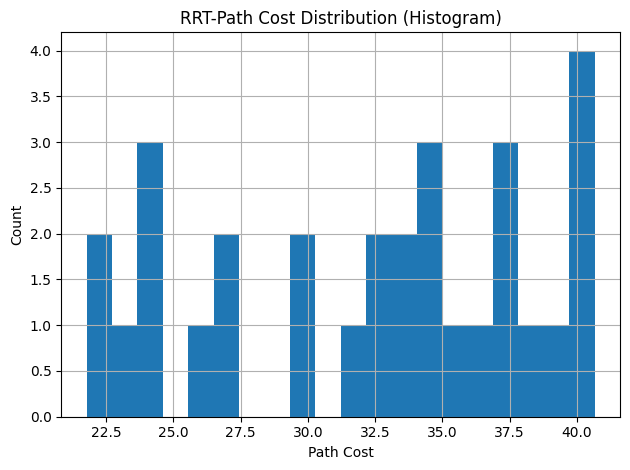

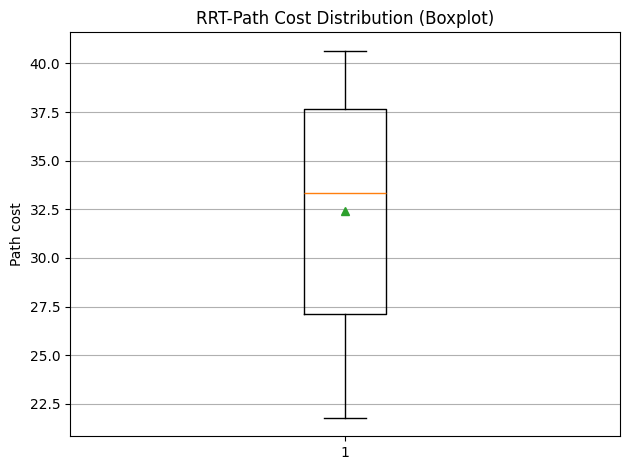

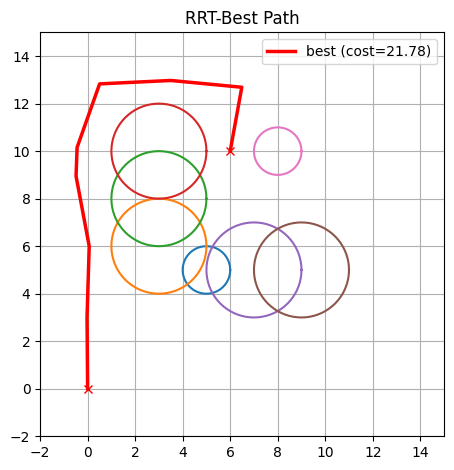

In [ ]:
"""

Path planning Sample Code with Randomized Rapidly-Exploring Random Trees (RRT)

author: AtsushiSakai(@Atsushi_twi)

"""

import math
import random

import matplotlib.pyplot as plt
import numpy as np

show_animation = True


class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    class AreaBounds:

        def __init__(self, area):
            self.xmin = float(area[0])
            self.xmax = float(area[1])
            self.ymin = float(area[2])
            self.ymax = float(area[3])


    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=3.0,
                 path_resolution=0.5,
                 goal_sample_rate=5,
                 max_iter=1500,
                 play_area=None,
                 robot_radius=0.0,
                 ):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        play_area:stay inside this area [xmin,xmax,ymin,ymax]
        robot_radius: robot body modeled as circle with given radius

        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        if play_area is not None:
            self.play_area = self.AreaBounds(play_area)
        else:
            self.play_area = None
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []
        self.robot_radius = robot_radius

    def planning(self, animation=True):
        """
        rrt path planning

        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_if_outside_play_area(new_node, self.play_area) and \
               self.check_collision(
                   new_node, self.obstacle_list, self.robot_radius):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(
                        final_node, self.obstacle_list, self.robot_radius):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                random.uniform(self.min_rand, self.max_rand),
                random.uniform(self.min_rand, self.max_rand))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
            if self.robot_radius > 0.0:
                self.plot_circle(rnd.x, rnd.y, self.robot_radius, '-r')
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)

        if self.play_area is not None:
            plt.plot([self.play_area.xmin, self.play_area.xmax,
                      self.play_area.xmax, self.play_area.xmin,
                      self.play_area.xmin],
                     [self.play_area.ymin, self.play_area.ymin,
                      self.play_area.ymax, self.play_area.ymax,
                      self.play_area.ymin],
                     "-k")

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([self.min_rand, self.max_rand, self.min_rand, self.max_rand])
        plt.grid(True)
        plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_if_outside_play_area(node, play_area):

        if play_area is None:
            return True  # no play_area was defined, every pos should be ok

        if node.x < play_area.xmin or node.x > play_area.xmax or \
           node.y < play_area.ymin or node.y > play_area.ymax:
            return False  # outside - bad
        else:
            return True  # inside - ok

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (size+robot_radius)**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta

def main(gx=6.0, gy=10.0):
    print("start ")

    # ====Search Path with RRT====
    obstacleList = [(5, 5, 1), (3, 6, 2), (3, 8, 2), (3, 10, 2), (7, 5, 2),
                    (9, 5, 2), (8, 10, 1)]  # [x, y, radius]

    # 2025143782 Dabeen-Yun =============================================

    start = [0, 0]
    goal = [gx, gy]
    rand_area = [-2, 15]
    # play_area=[0, 10, 0, 14]
    robot_radius = 0.8

    rrt_factory = make_planner_factory(
        start=start, goal=goal,
        rand_area=rand_area, obstacle_list=obstacleList,
        robot_radius=robot_radius, mode="RRT"
    )

    costs, optimal_path, optimal_bg_elements = run_experiments(
        planner_factory=rrt_factory,
        n_trials=30, seed=921
    )

    stats = report_summary_of_costs(costs)
    optimal_path_cost = compute_path_cost(optimal_path)

    if stats["n"] == 0:
      print("[RRT] ALL path fail")
      return

    print(f"[RRT] Optimal path cost = {optimal_path_cost}")

    print(f"[RRT] n={stats['n']} | mean={stats['mean']:.3f}, std={stats['std']:.3f}, "
          f"min={stats['min']:.3f}, max={stats['max']:.3f}, median={stats['median']:.3f}")

    plot_distribution(costs, mode="RRT")
    plot_optimal_path(optimal_path=optimal_path, mode="RRT",
                      bg_elements=optimal_bg_elements, background_drawer=rrt_background_drawer)

    plt.show()


if __name__ == '__main__':
    main()

reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached max iteration
NOOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooo
reached ma

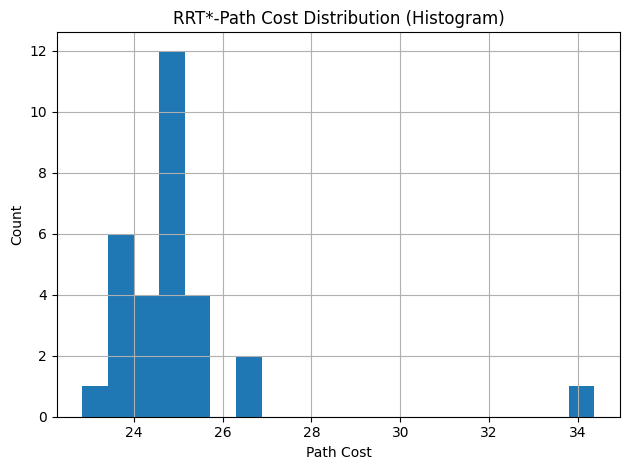

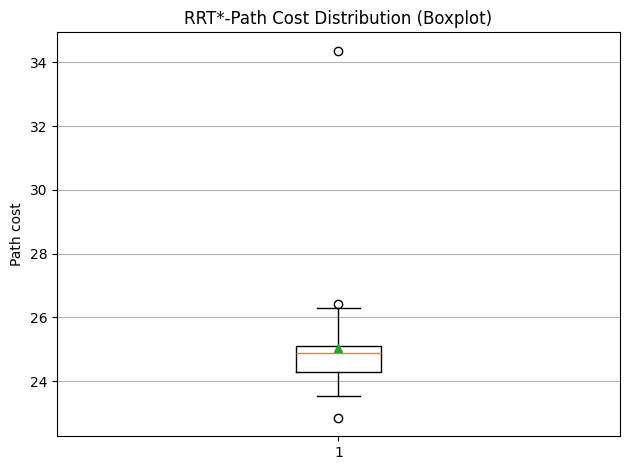

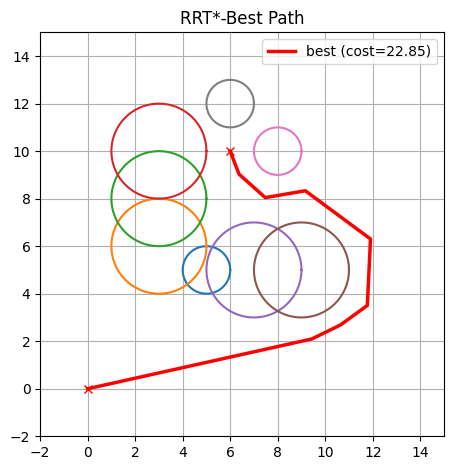

In [ ]:
"""

Path planning Sample Code with RRT*

author: Atsushi Sakai(@Atsushi_twi)

"""

import math
import sys
import matplotlib.pyplot as plt
import pathlib

show_animation = True

class RRTStar(RRT):
    """
    Class for RRT Star planning
    """

    class Node(RRT.Node):
        def __init__(self, x, y):
            super().__init__(x, y)
            self.cost = 0.0

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=30.0,
                 path_resolution=1.0,
                 goal_sample_rate=20,
                 max_iter=300,
                 connect_circle_dist=50.0,
                 search_until_max_iter=False,
                 robot_radius=0.0):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]

        """
        super().__init__(start, goal, obstacle_list, rand_area, expand_dis,
                         path_resolution, goal_sample_rate, max_iter,
                         robot_radius=robot_radius)
        self.connect_circle_dist = connect_circle_dist
        self.goal_node = self.Node(goal[0], goal[1])
        self.search_until_max_iter = search_until_max_iter
        self.node_list = []

    def planning(self, animation=True):
        """
        rrt star path planning

        animation: flag for animation on or off .
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            # print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)
            new_node = self.steer(self.node_list[nearest_ind], rnd,
                                  self.expand_dis)
            near_node = self.node_list[nearest_ind]
            new_node.cost = near_node.cost + \
                math.hypot(new_node.x-near_node.x,
                           new_node.y-near_node.y)

            if self.check_collision(
                    new_node, self.obstacle_list, self.robot_radius):
                near_inds = self.find_near_nodes(new_node)
                node_with_updated_parent = self.choose_parent(
                    new_node, near_inds)
                if node_with_updated_parent:
                    self.rewire(node_with_updated_parent, near_inds)
                    self.node_list.append(node_with_updated_parent)
                else:
                    self.node_list.append(new_node)

            if animation:
                self.draw_graph(rnd)

            if ((not self.search_until_max_iter)
                    and new_node):  # if reaches goal
                last_index = self.search_best_goal_node()
                if last_index is not None:
                    return self.generate_final_course(last_index)

        print("reached max iteration")

        last_index = self.search_best_goal_node()
        if last_index is not None:
            return self.generate_final_course(last_index)

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and th tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:
            near_node = self.node_list[i]
            t_node = self.steer(near_node, new_node)
            if t_node and self.check_collision(
                    t_node, self.obstacle_list, self.robot_radius):
                costs.append(self.calc_new_cost(near_node, new_node))
            else:
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]
        new_node = self.steer(self.node_list[min_ind], new_node)
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):
        dist_to_goal_list = [
            self.calc_dist_to_goal(n.x, n.y) for n in self.node_list
        ]
        goal_inds = [
            dist_to_goal_list.index(i) for i in dist_to_goal_list
            if i <= self.expand_dis
        ]

        safe_goal_inds = []
        for goal_ind in goal_inds:
            t_node = self.steer(self.node_list[goal_ind], self.goal_node)
            if self.check_collision(
                    t_node, self.obstacle_list, self.robot_radius):
                safe_goal_inds.append(goal_ind)

        if not safe_goal_inds:
            return None

        safe_goal_costs = [self.node_list[i].cost +
                           self.calc_dist_to_goal(self.node_list[i].x, self.node_list[i].y)
                           for i in safe_goal_inds]

        min_cost = min(safe_goal_costs)
        for i, cost in zip(safe_goal_inds, safe_goal_costs):
            if cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """
        1) defines a ball centered on new_node
        2) Returns all nodes of the three that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * math.sqrt(math.log(nnode) / nnode)
        # if expand_dist exists, search vertices in a range no more than
        # expand_dist
        if hasattr(self, 'expand_dis'):
            r = min(r, self.expand_dis)
        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(
                edge_node, self.obstacle_list, self.robot_radius)
            improved_cost = near_node.cost > edge_node.cost

            if no_collision and improved_cost:
                for node in self.node_list:
                    if node.parent == self.node_list[i]:
                        node.parent = edge_node
                self.node_list[i] = edge_node
                self.propagate_cost_to_leaves(self.node_list[i])

    def calc_new_cost(self, from_node, to_node):
        d, _ = self.calc_distance_and_angle(from_node, to_node)
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)


def main():
    # print("Start " + __file__)

    # ====Search Path with RRT====
    obstacle_list = [
        (5, 5, 1),
        (3, 6, 2),
        (3, 8, 2),
        (3, 10, 2),
        (7, 5, 2),
        (9, 5, 2),
        (8, 10, 1),
        (6, 12, 1),
    ]  # [x,y,size(radius)]

    # 2025143782 Dabeen-Yun =============================================
    start=[0, 0]
    goal=[6, 10]
    rand_area=[-2, 15]
    expand_dis=30
    robot_radius=0.8

    rrt_star_factory = make_planner_factory(
        start=start, goal=goal,
        rand_area=rand_area, obstacle_list=obstacle_list,
        expand_dis=expand_dis, robot_radius=robot_radius, mode="RRT*"
    )

    costs, optimal_path, optimal_bg_elements = run_experiments(
        planner_factory=rrt_star_factory,
        n_trials=30, seed=921
    )

    stats = report_summary_of_costs(costs)
    optimal_path_cost = compute_path_cost(optimal_path)

    if stats["n"] == 0:
        print("[RRT*] All path failed")
        return

    print(f"[RRT*] Optimal path cost = {optimal_path_cost}")
    print(f"[RRT*] n={stats['n']} | mean={stats['mean']:.3f}, std={stats['std']:.3f}, "
          f"min={stats['min']:.3f}, max={stats['max']:.3f}, median={stats['median']:.3f}")

    plot_distribution(costs, mode="RRT*")
    plot_optimal_path(optimal_path=optimal_path, mode="RRT*",
                      bg_elements=optimal_bg_elements, background_drawer=rrt_background_drawer)

    plt.show()


if __name__ == '__main__':
    main()

# Task 2
---

**변경한 함수**
1. obstacles
- 총 4개의 건물 외곽선을 형성하여 실제 도심 환경처럼 구성

2. goal
- 건물 외곽선과 상호작용할 수 있도록 위치 조정

start 
[RRT] Optimal path cost = 23.81896801306036
[RRT] n=30 | mean=27.676, std=2.571, min=23.819, max=31.737, median=27.327


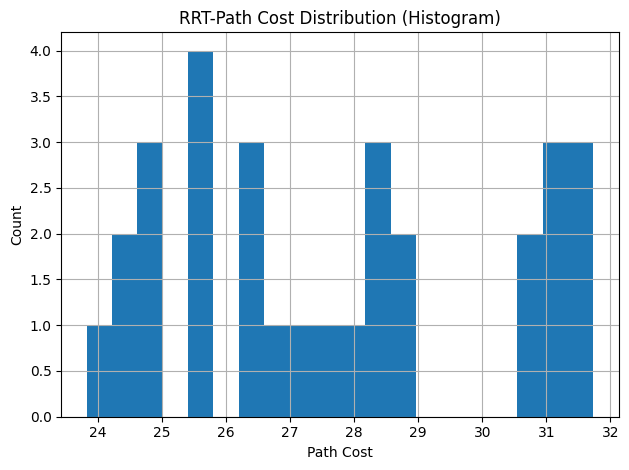

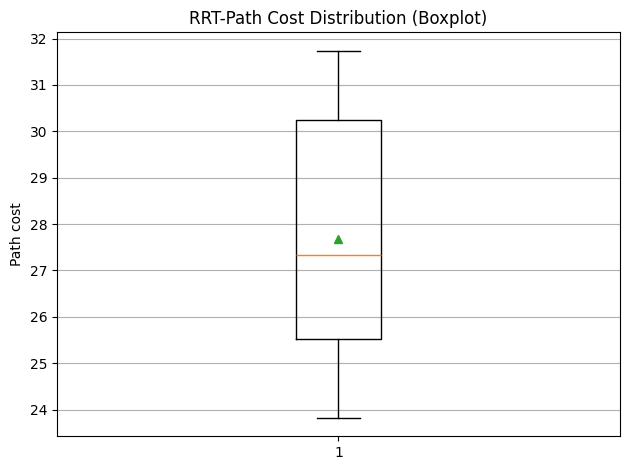

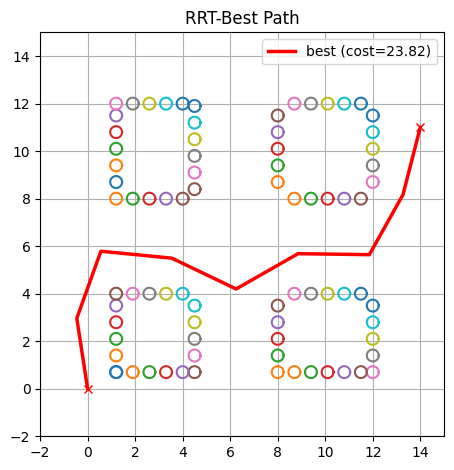

In [ ]:
"""

Path planning Sample Code with Randomized Rapidly-Exploring Random Trees (RRT)

author: AtsushiSakai(@Atsushi_twi)

"""

import math
import random

import matplotlib.pyplot as plt
import numpy as np

show_animation = True


class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    class AreaBounds:

        def __init__(self, area):
            self.xmin = float(area[0])
            self.xmax = float(area[1])
            self.ymin = float(area[2])
            self.ymax = float(area[3])


    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=3.0,
                 path_resolution=0.5,
                 goal_sample_rate=5,
                 max_iter=500,
                 play_area=None,
                 robot_radius=0.0,
                 ):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        play_area:stay inside this area [xmin,xmax,ymin,ymax]
        robot_radius: robot body modeled as circle with given radius

        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        if play_area is not None:
            self.play_area = self.AreaBounds(play_area)
        else:
            self.play_area = None
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []
        self.robot_radius = robot_radius

    def planning(self, animation=True):
        """
        rrt path planning

        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_if_outside_play_area(new_node, self.play_area) and \
               self.check_collision(
                   new_node, self.obstacle_list, self.robot_radius):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(
                        final_node, self.obstacle_list, self.robot_radius):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                random.uniform(self.min_rand, self.max_rand),
                random.uniform(self.min_rand, self.max_rand))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
            if self.robot_radius > 0.0:
                self.plot_circle(rnd.x, rnd.y, self.robot_radius, '-r')
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)

        if self.play_area is not None:
            plt.plot([self.play_area.xmin, self.play_area.xmax,
                      self.play_area.xmax, self.play_area.xmin,
                      self.play_area.xmin],
                     [self.play_area.ymin, self.play_area.ymin,
                      self.play_area.ymax, self.play_area.ymax,
                      self.play_area.ymin],
                     "-k")

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([self.min_rand, self.max_rand, self.min_rand, self.max_rand])
        plt.grid(True)
        plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_if_outside_play_area(node, play_area):

        if play_area is None:
            return True  # no play_area was defined, every pos should be ok

        if node.x < play_area.xmin or node.x > play_area.xmax or \
           node.y < play_area.ymin or node.y > play_area.ymax:
            return False  # outside - bad
        else:
            return True  # inside - ok

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (size+robot_radius)**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta

def main(gx=14.0, gy=11.0):
    print("start ")

    # ====Search Path with RRT====
    # 2025143782 Dabeen-Yun =============================================
    obstacleList = [
        # left lower building
        (1.2, 0.7, 0.25), (1.2, 1.4, 0.25), (1.2, 2.1, 0.25), (1.2, 2.8, 0.25), (1.2, 3.5, 0.25),
        (4.5, 0.7, 0.25), (4.5, 1.4, 0.25), (4.5, 2.1, 0.25), (4.5, 2.8, 0.25), (4.5, 3.5, 0.25),
        (1.2, 0.7, 0.25), (1.9, 0.7, 0.25), (2.6, 0.7, 0.25), (3.3, 0.7, 0.25), (4.0, 0.7, 0.25),
        (1.2, 4.0, 0.25), (1.9, 4.0, 0.25), (2.6, 4.0, 0.25), (3.3, 4.0, 0.25), (4.0, 4.0, 0.25),

        # left upper building
        (1.2, 8.7, 0.25), (1.2, 9.4, 0.25), (1.2, 10.1, 0.25), (1.2, 10.8, 0.25), (1.2, 11.5, 0.25),
        (4.5, 8.4, 0.25), (4.5, 9.1, 0.25), (4.5, 9.8, 0.25), (4.5, 10.5, 0.25), (4.5, 11.2, 0.25), (4.5, 11.9, 0.25),
        (1.2, 8.0, 0.25), (1.9, 8.0, 0.25), (2.6, 8.0, 0.25), (3.3, 8.0, 0.25), (4.0, 8.0, 0.25),
        (1.2, 12.0, 0.25), (1.9, 12.0, 0.25), (2.6, 12.0, 0.25), (3.3, 12.0, 0.25), (4.0, 12.0, 0.25),

        # right lower building
        (8.0, 0.7, 0.25), (8.0, 1.4, 0.25), (8.0, 2.1, 0.25), (8.0, 2.8, 0.25), (8.0, 3.5, 0.25),
        (12.0, 0.7, 0.25), (12.0, 1.4, 0.25), (12.0, 2.1, 0.25), (12.0, 2.8, 0.25), (12.0, 3.5, 0.25),
        (8.7, 0.7, 0.25), (9.4, 0.7, 0.25), (10.1, 0.7, 0.25), (10.8, 0.7, 0.25), (11.5, 0.7, 0.25),
        (8.7, 4.0, 0.25), (9.4, 4.0, 0.25), (10.1, 4.0, 0.25), (10.8, 4.0, 0.25), (11.5, 4.0, 0.25),

        # right upper buliding
        (8.0, 8.7, 0.25), (8.0, 9.4, 0.25), (8.0, 10.1, 0.25), (8.0, 10.8, 0.25), (8.0, 11.5, 0.25),
        (12.0, 8.7, 0.25), (12.0, 9.4, 0.25), (12.0, 10.1, 0.25), (12.0, 10.8, 0.25), (12.0, 11.5, 0.25),
        (8.7, 8.0, 0.25), (9.4, 8.0, 0.25), (10.1, 8.0, 0.25), (10.8, 8.0, 0.25), (11.5, 8.0, 0.25),
        (8.7, 12.0, 0.25), (9.4, 12.0, 0.25), (10.1, 12.0, 0.25), (10.8, 12.0, 0.25), (11.5, 12.0, 0.25),
    ]  # [x, y, radius]

    start = [0, 0]
    goal = [gx, gy]
    rand_area = [-2, 15]
    # play_area=[0, 10, 0, 14]
    robot_radius = 0.8

    rrt_factory = make_planner_factory(
        start=start, goal=goal,
        rand_area=rand_area, obstacle_list=obstacleList,
        robot_radius=robot_radius, mode="RRT"
    )

    costs, optimal_path, optimal_bg_elements = run_experiments(
        planner_factory=rrt_factory,
        n_trials=30, seed=921
    )

    stats = report_summary_of_costs(costs)
    optimal_path_cost = compute_path_cost(optimal_path)

    if stats["n"] == 0:
      print("[RRT] ALL path fail")
      return

    print(f"[RRT] Optimal path cost = {optimal_path_cost}")

    print(f"[RRT] n={stats['n']} | mean={stats['mean']:.3f}, std={stats['std']:.3f}, "
          f"min={stats['min']:.3f}, max={stats['max']:.3f}, median={stats['median']:.3f}")

    plot_distribution(costs, mode="RRT")
    plot_optimal_path(optimal_path=optimal_path, mode="RRT",
                      bg_elements=optimal_bg_elements, background_drawer=rrt_background_drawer)

    plt.show()


if __name__ == '__main__':
    main()

[RRT*] Optimal path cost = 23.179492684417013
[RRT*] n=30 | mean=27.732, std=2.686, min=23.179, max=32.366, median=28.870


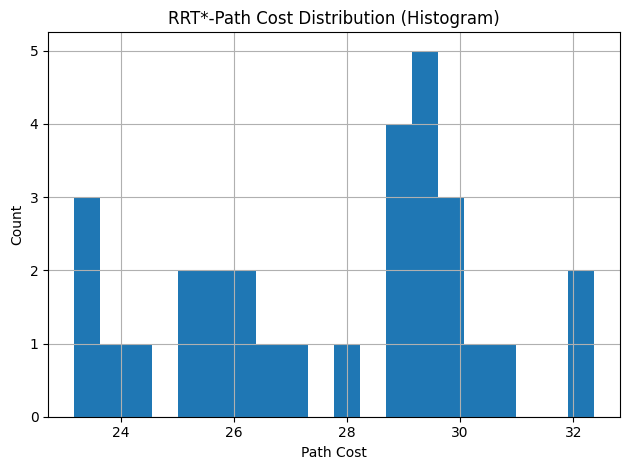

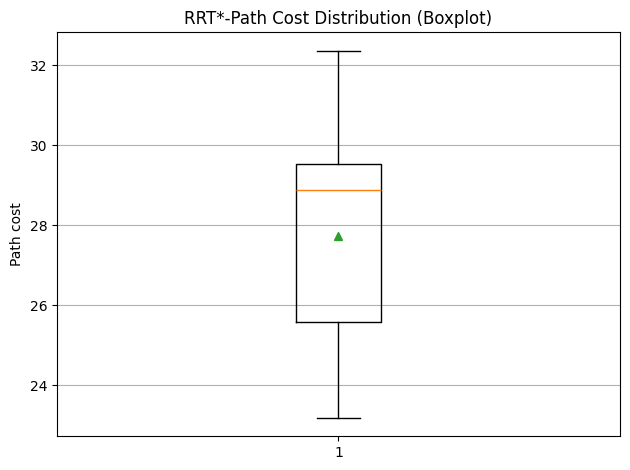

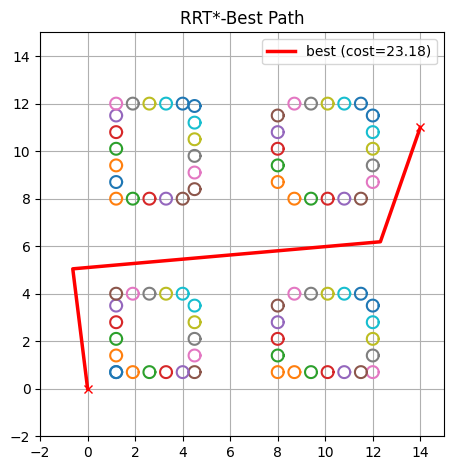

In [ ]:
"""

Path planning Sample Code with RRT*

author: Atsushi Sakai(@Atsushi_twi)

"""

import math
import sys
import matplotlib.pyplot as plt
import pathlib

show_animation = True

class RRTStar(RRT):
    """
    Class for RRT Star planning
    """

    class Node(RRT.Node):
        def __init__(self, x, y):
            super().__init__(x, y)
            self.cost = 0.0

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=30.0,
                 path_resolution=1.0,
                 goal_sample_rate=20,
                 max_iter=300,
                 connect_circle_dist=50.0,
                 search_until_max_iter=False,
                 robot_radius=0.0):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]

        """
        super().__init__(start, goal, obstacle_list, rand_area, expand_dis,
                         path_resolution, goal_sample_rate, max_iter,
                         robot_radius=robot_radius)
        self.connect_circle_dist = connect_circle_dist
        self.goal_node = self.Node(goal[0], goal[1])
        self.search_until_max_iter = search_until_max_iter
        self.node_list = []

    def planning(self, animation=True):
        """
        rrt star path planning

        animation: flag for animation on or off .
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            # print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)
            new_node = self.steer(self.node_list[nearest_ind], rnd,
                                  self.expand_dis)
            near_node = self.node_list[nearest_ind]
            new_node.cost = near_node.cost + \
                math.hypot(new_node.x-near_node.x,
                           new_node.y-near_node.y)

            if self.check_collision(
                    new_node, self.obstacle_list, self.robot_radius):
                near_inds = self.find_near_nodes(new_node)
                node_with_updated_parent = self.choose_parent(
                    new_node, near_inds)
                if node_with_updated_parent:
                    self.rewire(node_with_updated_parent, near_inds)
                    self.node_list.append(node_with_updated_parent)
                else:
                    self.node_list.append(new_node)

            if animation:
                self.draw_graph(rnd)

            if ((not self.search_until_max_iter)
                    and new_node):  # if reaches goal
                last_index = self.search_best_goal_node()
                if last_index is not None:
                    return self.generate_final_course(last_index)

        print("reached max iteration")

        last_index = self.search_best_goal_node()
        if last_index is not None:
            return self.generate_final_course(last_index)

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and th tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:
            near_node = self.node_list[i]
            t_node = self.steer(near_node, new_node)
            if t_node and self.check_collision(
                    t_node, self.obstacle_list, self.robot_radius):
                costs.append(self.calc_new_cost(near_node, new_node))
            else:
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]
        new_node = self.steer(self.node_list[min_ind], new_node)
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):
        dist_to_goal_list = [
            self.calc_dist_to_goal(n.x, n.y) for n in self.node_list
        ]
        goal_inds = [
            dist_to_goal_list.index(i) for i in dist_to_goal_list
            if i <= self.expand_dis
        ]

        safe_goal_inds = []
        for goal_ind in goal_inds:
            t_node = self.steer(self.node_list[goal_ind], self.goal_node)
            if self.check_collision(
                    t_node, self.obstacle_list, self.robot_radius):
                safe_goal_inds.append(goal_ind)

        if not safe_goal_inds:
            return None

        safe_goal_costs = [self.node_list[i].cost +
                           self.calc_dist_to_goal(self.node_list[i].x, self.node_list[i].y)
                           for i in safe_goal_inds]

        min_cost = min(safe_goal_costs)
        for i, cost in zip(safe_goal_inds, safe_goal_costs):
            if cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """
        1) defines a ball centered on new_node
        2) Returns all nodes of the three that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * math.sqrt(math.log(nnode) / nnode)
        # if expand_dist exists, search vertices in a range no more than
        # expand_dist
        if hasattr(self, 'expand_dis'):
            r = min(r, self.expand_dis)
        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(
                edge_node, self.obstacle_list, self.robot_radius)
            improved_cost = near_node.cost > edge_node.cost

            if no_collision and improved_cost:
                for node in self.node_list:
                    if node.parent == self.node_list[i]:
                        node.parent = edge_node
                self.node_list[i] = edge_node
                self.propagate_cost_to_leaves(self.node_list[i])

    def calc_new_cost(self, from_node, to_node):
        d, _ = self.calc_distance_and_angle(from_node, to_node)
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)


def main():
    # print("Start " + __file__)

    # ====Search Path with RRT====
    obstacle_list = [
        # left lower building
        (1.2, 0.7, 0.25), (1.2, 1.4, 0.25), (1.2, 2.1, 0.25), (1.2, 2.8, 0.25), (1.2, 3.5, 0.25),
        (4.5, 0.7, 0.25), (4.5, 1.4, 0.25), (4.5, 2.1, 0.25), (4.5, 2.8, 0.25), (4.5, 3.5, 0.25),
        (1.2, 0.7, 0.25), (1.9, 0.7, 0.25), (2.6, 0.7, 0.25), (3.3, 0.7, 0.25), (4.0, 0.7, 0.25),
        (1.2, 4.0, 0.25), (1.9, 4.0, 0.25), (2.6, 4.0, 0.25), (3.3, 4.0, 0.25), (4.0, 4.0, 0.25),

        # left upper building
        (1.2, 8.7, 0.25), (1.2, 9.4, 0.25), (1.2, 10.1, 0.25), (1.2, 10.8, 0.25), (1.2, 11.5, 0.25),
        (4.5, 8.4, 0.25), (4.5, 9.1, 0.25), (4.5, 9.8, 0.25), (4.5, 10.5, 0.25), (4.5, 11.2, 0.25), (4.5, 11.9, 0.25),
        (1.2, 8.0, 0.25), (1.9, 8.0, 0.25), (2.6, 8.0, 0.25), (3.3, 8.0, 0.25), (4.0, 8.0, 0.25),
        (1.2, 12.0, 0.25), (1.9, 12.0, 0.25), (2.6, 12.0, 0.25), (3.3, 12.0, 0.25), (4.0, 12.0, 0.25),

        # right lower building
        (8.0, 0.7, 0.25), (8.0, 1.4, 0.25), (8.0, 2.1, 0.25), (8.0, 2.8, 0.25), (8.0, 3.5, 0.25),
        (12.0, 0.7, 0.25), (12.0, 1.4, 0.25), (12.0, 2.1, 0.25), (12.0, 2.8, 0.25), (12.0, 3.5, 0.25),
        (8.7, 0.7, 0.25), (9.4, 0.7, 0.25), (10.1, 0.7, 0.25), (10.8, 0.7, 0.25), (11.5, 0.7, 0.25),
        (8.7, 4.0, 0.25), (9.4, 4.0, 0.25), (10.1, 4.0, 0.25), (10.8, 4.0, 0.25), (11.5, 4.0, 0.25),

        # right upper buliding
        (8.0, 8.7, 0.25), (8.0, 9.4, 0.25), (8.0, 10.1, 0.25), (8.0, 10.8, 0.25), (8.0, 11.5, 0.25),
        (12.0, 8.7, 0.25), (12.0, 9.4, 0.25), (12.0, 10.1, 0.25), (12.0, 10.8, 0.25), (12.0, 11.5, 0.25),
        (8.7, 8.0, 0.25), (9.4, 8.0, 0.25), (10.1, 8.0, 0.25), (10.8, 8.0, 0.25), (11.5, 8.0, 0.25),
        (8.7, 12.0, 0.25), (9.4, 12.0, 0.25), (10.1, 12.0, 0.25), (10.8, 12.0, 0.25), (11.5, 12.0, 0.25),
    ]  # [x,y,size(radius)]

    # 2025143782 Dabeen-Yun =============================================
    start=[0, 0]
    goal=[14, 11]
    rand_area=[-2, 15]
    expand_dis=30
    robot_radius=0.8

    rrt_star_factory = make_planner_factory(
        start=start, goal=goal,
        rand_area=rand_area, obstacle_list=obstacle_list,
        expand_dis=expand_dis, robot_radius=robot_radius, mode="RRT*"
    )

    costs, optimal_path, optimal_bg_elements = run_experiments(
        planner_factory=rrt_star_factory,
        n_trials=30, seed=921
    )

    stats = report_summary_of_costs(costs)
    optimal_path_cost = compute_path_cost(optimal_path)

    if stats["n"] == 0:
        print("[RRT*] All path failed")
        return

    print(f"[RRT*] Optimal path cost = {optimal_path_cost}")

    print(f"[RRT*] n={stats['n']} | mean={stats['mean']:.3f}, std={stats['std']:.3f}, "
          f"min={stats['min']:.3f}, max={stats['max']:.3f}, median={stats['median']:.3f}")

    plot_distribution(costs, mode="RRT*")
    plot_optimal_path(optimal_path=optimal_path, mode="RRT*",
                      bg_elements=optimal_bg_elements, background_drawer=rrt_background_drawer)

    plt.show()


if __name__ == '__main__':
    main()

# Task 3

In [1]:
# 2025143782 Dabeen-Yun
import time


def path_length(path):
    # path: [[x,y], ...] (끝에서 시작으로 역순 포함)
    if path is None or len(path) < 2:
        return float("nan")
    L = 0.0
    for i in range(1, len(path)):
        x0, y0 = path[i-1]
        x1, y1 = path[i]
        L += math.hypot(x1 - x0, y1 - y0)
    return L

def run_rrt_once(obstacle_list, start, goal,
                 rand_area, robot_radius,
                 expand_dis, goal_sample_rate,
                 path_resolution=None,
                 max_iter=500,
                 seed=None, mode="RRT"):
    # 재현성
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    if path_resolution is None:
        # 좁은 통로에서도 안정적이도록 expand_dis/5 권장
        path_resolution = max(0.15, expand_dis / 5.0)
    if mode == "RRT":
      rrt = RRT(
          start=start, goal=goal,
          rand_area=rand_area,
          obstacle_list=obstacle_list,
          robot_radius=robot_radius,
          expand_dis=expand_dis,
          path_resolution=path_resolution,
          goal_sample_rate=goal_sample_rate,
          max_iter=max_iter,
      )
      t0 = time.perf_counter()
      path = rrt.planning(animation=False)
      t1 = time.perf_counter()
    elif mode == "RRTstar":
      rrt_star = RRTStar(
        start=[0, 0],
        goal=[6, 10],
        rand_area=[-2, 15],
        obstacle_list=obstacle_list,
        expand_dis=1,
        robot_radius=0.8)
      t0 = time.perf_counter()
      path = rrt_star.planning(animation=False)
      t1 = time.perf_counter()

    success = 1 if path is not None else 0
    cost = path_length(path) if success else float("nan")
    runtime = (t1 - t0)
    return success, cost, runtime

def sweep_grid(obstacle_list,
               start=[0,0], goal=[6.0,10.0],
               rand_area=[0.0,14.0],
               robot_radius=0.8,
               expand_vals=(3.0, 7.5, 12.0, 16.5, 21.0, 25.5, 30.0),
               goal_sample_vals=(5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0),
               n_trials=30, max_iter=500, mode="RRT"):
    E = len(expand_vals)
    G = len(goal_sample_vals)
    mean_cost = np.full((E, G), np.nan)
    success_rate = np.zeros((E, G), dtype=float)
    mean_runtime = np.zeros((E, G), dtype=float)

    for ei, ed in enumerate(expand_vals):
        for gi, gs in enumerate(goal_sample_vals):
            succs = []
            costs = []
            times = []
            for k in range(n_trials):
                s, c, rt = run_rrt_once(
                    obstacle_list=obstacle_list,
                    start=start, goal=goal,
                    rand_area=rand_area,
                    robot_radius=robot_radius,
                    expand_dis=ed,
                    goal_sample_rate=gs,
                    path_resolution=None,
                    max_iter=max_iter,
                    seed=921, mode=mode
                )
                succs.append(s)
                times.append(rt)
                if s:
                    costs.append(c)

            success_rate[ei, gi] = np.mean(succs)
            mean_runtime[ei, gi] = np.mean(times)
            # 실패가 섞이면 비용은 성공 케이스 평균만 사용
            mean_cost[ei, gi] = np.mean(costs) if len(costs) > 0 else np.nan

    return np.array(expand_vals), np.array(goal_sample_vals), mean_cost, success_rate, mean_runtime

def plot_heatmap(ax, Z, x_ticks, y_ticks, title, cbar_label):
    m = ax.imshow(Z, origin="lower", aspect="auto",
                  extent=[x_ticks[0]-0.5, x_ticks[-1]+0.5, y_ticks[0]-0.5, y_ticks[-1]+0.5])
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xlabel("goal_sample_rate")
    ax.set_ylabel("expand_dis")
    ax.set_title(title)
    cbar = plt.colorbar(m, ax=ax, shrink=0.85)
    cbar.set_label(cbar_label)


start 


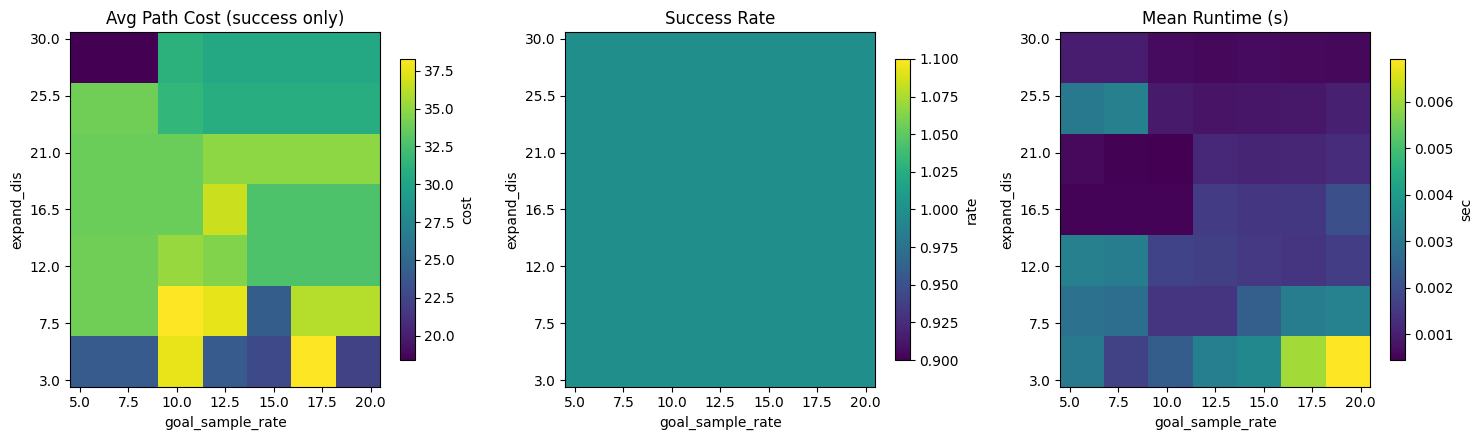


=== Sweep Summary ===
Best success rate: 1.00 at expand_dis=3.0, goal_sample_rate=5.0
Lowest avg cost: 18.39 at expand_dis=30.0, goal_sample_rate=5.0


In [2]:
"""

Path planning Sample Code with Randomized Rapidly-Exploring Random Trees (RRT)

author: AtsushiSakai(@Atsushi_twi)

"""

import math
import random

import matplotlib.pyplot as plt
import numpy as np

show_animation = True


class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    class AreaBounds:

        def __init__(self, area):
            self.xmin = float(area[0])
            self.xmax = float(area[1])
            self.ymin = float(area[2])
            self.ymax = float(area[3])


    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=3.0,
                 path_resolution=0.5,
                 goal_sample_rate=5,
                 max_iter=500,
                 play_area=None,
                 robot_radius=0.0,
                 ):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        play_area:stay inside this area [xmin,xmax,ymin,ymax]
        robot_radius: robot body modeled as circle with given radius

        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        if play_area is not None:
            self.play_area = self.AreaBounds(play_area)
        else:
            self.play_area = None
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []
        self.robot_radius = robot_radius

    def planning(self, animation=True):
        """
        rrt path planning

        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_if_outside_play_area(new_node, self.play_area) and \
               self.check_collision(
                   new_node, self.obstacle_list, self.robot_radius):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(
                        final_node, self.obstacle_list, self.robot_radius):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                random.uniform(self.min_rand, self.max_rand),
                random.uniform(self.min_rand, self.max_rand))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
            if self.robot_radius > 0.0:
                self.plot_circle(rnd.x, rnd.y, self.robot_radius, '-r')
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)

        if self.play_area is not None:
            plt.plot([self.play_area.xmin, self.play_area.xmax,
                      self.play_area.xmax, self.play_area.xmin,
                      self.play_area.xmin],
                     [self.play_area.ymin, self.play_area.ymin,
                      self.play_area.ymax, self.play_area.ymax,
                      self.play_area.ymin],
                     "-k")

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([self.min_rand, self.max_rand, self.min_rand, self.max_rand])
        plt.grid(True)
        plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_if_outside_play_area(node, play_area):

        if play_area is None:
            return True  # no play_area was defined, every pos should be ok

        if node.x < play_area.xmin or node.x > play_area.xmax or \
           node.y < play_area.ymin or node.y > play_area.ymax:
            return False  # outside - bad
        else:
            return True  # inside - ok

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (size+robot_radius)**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta


def main(gx=6.0, gy=10.0):
    print("start ")

    # ====Search Path with RRT====
    obstacleList = [(5, 5, 1), (3, 6, 2), (3, 8, 2), (3, 10, 2), (7, 5, 2),
                    (9, 5, 2), (8, 10, 1)]  # [x, y, radius]

    # 2025143782 Dabeen-Yun
    start = [0, 0]
    goal = [gx, gy]
    rand_area = [-2, 15]
    robot_radius = 0.8

    expand_vals = [3.0, 7.5, 12.0, 16.5, 21.0, 25.5, 30.0]
    goal_sample_vals = [5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0]

    E, G, mean_cost, success_rate, mean_runtime = sweep_grid(
        obstacle_list=obstacleList,
        start=start, goal=goal,
        rand_area=rand_area,
        robot_radius=robot_radius,
        expand_vals=expand_vals,
        goal_sample_vals=goal_sample_vals,
        n_trials=30,
        max_iter=1500
    )

    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
    plot_heatmap(axes[0], mean_cost, goal_sample_vals, expand_vals,
                 "Avg Path Cost (success only)", "cost")
    plot_heatmap(axes[1], success_rate, goal_sample_vals, expand_vals,
                 "Success Rate", "rate")
    plot_heatmap(axes[2], mean_runtime, goal_sample_vals, expand_vals,
                 "Mean Runtime (s)", "sec")

    plt.tight_layout()
    plt.show()

    # 5) 간단 해석(텍스트)
    # - 가장 높은 성공률 위치, 가장 낮은 비용 위치 출력
    #   (성공률이 0인 곳의 비용은 NaN이므로 제외)
    best_sr_idx = np.unravel_index(np.nanargmax(success_rate), success_rate.shape)
    finite_mask = ~np.isnan(mean_cost)
    if finite_mask.any():
        best_cost_idx = np.unravel_index(np.nanargmin(mean_cost[finite_mask]), success_rate.shape)
    else:
        best_cost_idx = None

    print("\n=== Sweep Summary ===")
    print(f"Best success rate: {success_rate[best_sr_idx]:.2f} at "
          f"expand_dis={expand_vals[best_sr_idx[0]]}, goal_sample_rate={goal_sample_vals[best_sr_idx[1]]}")
    if best_cost_idx is not None:
        print(f"Lowest avg cost: {mean_cost[best_cost_idx]:.2f} at "
              f"expand_dis={expand_vals[best_cost_idx[0]]}, goal_sample_rate={goal_sample_vals[best_cost_idx[1]]}")
    else:
        print("No successful runs to compute average cost.")

if __name__ == '__main__':
    main()

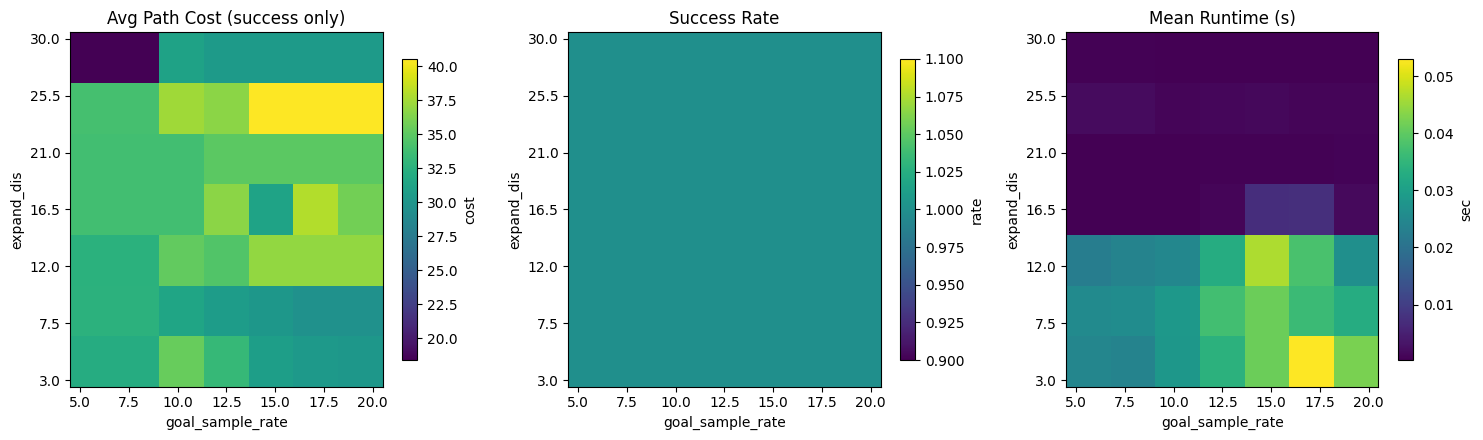


=== Sweep Summary ===
Best success rate: 1.00 at expand_dis=3.0, goal_sample_rate=5.0
Lowest avg cost: 18.39 at expand_dis=30.0, goal_sample_rate=5.0


In [3]:
"""

Path planning Sample Code with RRT*

author: Atsushi Sakai(@Atsushi_twi)

"""

import math
import sys
import matplotlib.pyplot as plt
import pathlib

show_animation = True

class RRTStar(RRT):
    """
    Class for RRT Star planning
    """

    class Node(RRT.Node):
        def __init__(self, x, y):
            super().__init__(x, y)
            self.cost = 0.0

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=30.0,
                 path_resolution=1.0,
                 goal_sample_rate=20,
                 max_iter=300,
                 connect_circle_dist=50.0,
                 search_until_max_iter=False,
                 robot_radius=0.0):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]

        """
        super().__init__(start, goal, obstacle_list, rand_area, expand_dis,
                         path_resolution, goal_sample_rate, max_iter,
                         robot_radius=robot_radius)
        self.connect_circle_dist = connect_circle_dist
        self.goal_node = self.Node(goal[0], goal[1])
        self.search_until_max_iter = search_until_max_iter
        self.node_list = []

    def planning(self, animation=True):
        """
        rrt star path planning

        animation: flag for animation on or off .
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)
            new_node = self.steer(self.node_list[nearest_ind], rnd,
                                  self.expand_dis)
            near_node = self.node_list[nearest_ind]
            new_node.cost = near_node.cost + \
                math.hypot(new_node.x-near_node.x,
                           new_node.y-near_node.y)

            if self.check_collision(
                    new_node, self.obstacle_list, self.robot_radius):
                near_inds = self.find_near_nodes(new_node)
                node_with_updated_parent = self.choose_parent(
                    new_node, near_inds)
                if node_with_updated_parent:
                    self.rewire(node_with_updated_parent, near_inds)
                    self.node_list.append(node_with_updated_parent)
                else:
                    self.node_list.append(new_node)

            if animation:
                self.draw_graph(rnd)

            if ((not self.search_until_max_iter)
                    and new_node):  # if reaches goal
                last_index = self.search_best_goal_node()
                if last_index is not None:
                    return self.generate_final_course(last_index)

        print("reached max iteration")

        last_index = self.search_best_goal_node()
        if last_index is not None:
            return self.generate_final_course(last_index)

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and th tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:
            near_node = self.node_list[i]
            t_node = self.steer(near_node, new_node)
            if t_node and self.check_collision(
                    t_node, self.obstacle_list, self.robot_radius):
                costs.append(self.calc_new_cost(near_node, new_node))
            else:
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]
        new_node = self.steer(self.node_list[min_ind], new_node)
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):
        dist_to_goal_list = [
            self.calc_dist_to_goal(n.x, n.y) for n in self.node_list
        ]
        goal_inds = [
            dist_to_goal_list.index(i) for i in dist_to_goal_list
            if i <= self.expand_dis
        ]

        safe_goal_inds = []
        for goal_ind in goal_inds:
            t_node = self.steer(self.node_list[goal_ind], self.goal_node)
            if self.check_collision(
                    t_node, self.obstacle_list, self.robot_radius):
                safe_goal_inds.append(goal_ind)

        if not safe_goal_inds:
            return None

        safe_goal_costs = [self.node_list[i].cost +
                           self.calc_dist_to_goal(self.node_list[i].x, self.node_list[i].y)
                           for i in safe_goal_inds]

        min_cost = min(safe_goal_costs)
        for i, cost in zip(safe_goal_inds, safe_goal_costs):
            if cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """
        1) defines a ball centered on new_node
        2) Returns all nodes of the three that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * math.sqrt(math.log(nnode) / nnode)
        # if expand_dist exists, search vertices in a range no more than
        # expand_dist
        if hasattr(self, 'expand_dis'):
            r = min(r, self.expand_dis)
        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(
                edge_node, self.obstacle_list, self.robot_radius)
            improved_cost = near_node.cost > edge_node.cost

            if no_collision and improved_cost:
                for node in self.node_list:
                    if node.parent == self.node_list[i]:
                        node.parent = edge_node
                self.node_list[i] = edge_node
                self.propagate_cost_to_leaves(self.node_list[i])

    def calc_new_cost(self, from_node, to_node):
        d, _ = self.calc_distance_and_angle(from_node, to_node)
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)


def main():
    # print("Start " + __file__)

    # ====Search Path with RRT====
    obstacle_list = [
        (5, 5, 1),
        (3, 6, 2),
        (3, 8, 2),
        (3, 10, 2),
        (7, 5, 2),
        (9, 5, 2),
        (8, 10, 1),
        (6, 12, 1),
    ]  # [x,y,size(radius)]

    # 2025143782 Dabeen-Yun
    start = [0, 0]
    goal = [6, 10]
    rand_area = [-2, 15]
    robot_radius = 0.8

    expand_vals = [3.0, 7.5, 12.0, 16.5, 21.0, 25.5, 30.0]
    goal_sample_vals = [5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0]

    # 3) 스윕 실행
    E, G, mean_cost, success_rate, mean_runtime = sweep_grid(
        obstacle_list=obstacle_list,
        start=start, goal=goal,
        rand_area=rand_area,
        robot_radius=robot_radius,
        expand_vals=expand_vals,
        goal_sample_vals=goal_sample_vals,
        n_trials=30,
        max_iter=1500
    )

    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
    plot_heatmap(axes[0], mean_cost, goal_sample_vals, expand_vals,
                 "Avg Path Cost (success only)", "cost")
    plot_heatmap(axes[1], success_rate, goal_sample_vals, expand_vals,
                 "Success Rate", "rate")
    plot_heatmap(axes[2], mean_runtime, goal_sample_vals, expand_vals,
                 "Mean Runtime (s)", "sec")

    plt.tight_layout()
    plt.show()

    # 5) 간단 해석(텍스트)
    # - 가장 높은 성공률 위치, 가장 낮은 비용 위치 출력
    #   (성공률이 0인 곳의 비용은 NaN이므로 제외)
    best_sr_idx = np.unravel_index(np.nanargmax(success_rate), success_rate.shape)
    finite_mask = ~np.isnan(mean_cost)
    if finite_mask.any():
        best_cost_idx = np.unravel_index(np.nanargmin(mean_cost[finite_mask]), success_rate.shape)
    else:
        best_cost_idx = None

    print("\n=== Sweep Summary ===")
    print(f"Best success rate: {success_rate[best_sr_idx]:.2f} at "
          f"expand_dis={expand_vals[best_sr_idx[0]]}, goal_sample_rate={goal_sample_vals[best_sr_idx[1]]}")
    if best_cost_idx is not None:
        print(f"Lowest avg cost: {mean_cost[best_cost_idx]:.2f} at "
              f"expand_dis={expand_vals[best_cost_idx[0]]}, goal_sample_rate={goal_sample_vals[best_cost_idx[1]]}")
    else:
        print("No successful runs to compute average cost.")


if __name__ == '__main__':
    main()

# Task 4

start 
[Euclid] found path!!
[Dubins] found path!!


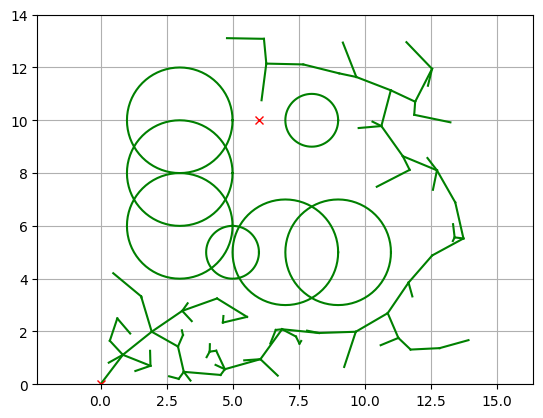

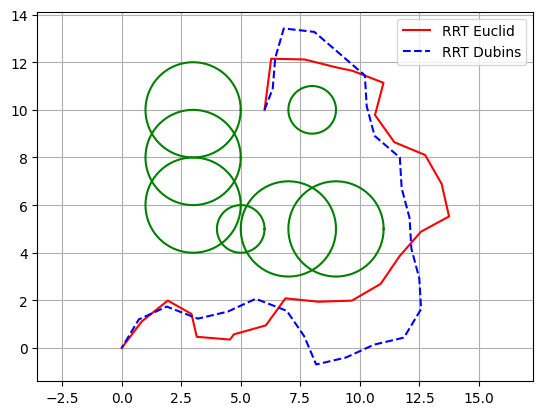

In [21]:
"""

Path planning Sample Code with Randomized Rapidly-Exploring Random Trees (RRT)

author: AtsushiSakai(@Atsushi_twi)

"""

import math
import random

import matplotlib.pyplot as plt
import numpy as np

show_animation = True

random.seed(999)
np.random.seed(999)

class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y, yaw=None): # 2025143782 Dabeen-Yun yaw 추가
            self.x = x
            self.y = y
            self.yaw = yaw
            self.path_x = []
            self.path_y = []
            self.parent = None

    class AreaBounds:

        def __init__(self, area):
            self.xmin = float(area[0])
            self.xmax = float(area[1])
            self.ymin = float(area[2])
            self.ymax = float(area[3])


    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,

                 # 2025143782 Dabeen-Yun
                 expand_dis=1.5,
                 path_resolution=0.2,
                 goal_sample_rate=5,
                 max_iter=1500,
                 play_area=None,
                 robot_radius=0.0,

                 use_dubins=False,
                 min_turning_radius=1.0,
                 ):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        play_area:stay inside this area [xmin,xmax,ymin,ymax]
        robot_radius: robot body modeled as circle with given radius

        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        if play_area is not None:
            self.play_area = self.AreaBounds(play_area)
        else:
            self.play_area = None
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []
        self.robot_radius = robot_radius

        # 2025143782 Dabeen-Yun
        self.use_dubins = bool(use_dubins)
        self.min_turning_radius = float(min_turning_radius)

        if self.start.yaw is None:
          self.start.yaw = math.atan2(self.end.y - self.start.y,
                                      self.end.x - self.start.x)

    def planning(self, animation=True):
        """
        rrt path planning

        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_if_outside_play_area(new_node, self.play_area) and \
               self.check_collision(
                   new_node, self.obstacle_list, self.robot_radius):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(
                        final_node, self.obstacle_list, self.robot_radius):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    # 2025143782 Dabeen-Yun
    def steer(self, from_node, to_node, extend_length=float("inf")):
      if self.use_dubins:
        return self.steer_dubins(from_node, to_node, extend_length)
      else:
        return self.steer_euclidean(from_node, to_node, extend_length)

    def steer_euclidean(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y, from_node.yaw)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def steer_dubins(self, from_node, to_node, extend_length=float("inf")):
        from_yaw = from_node.yaw
        if from_yaw is None:
            _, th = self.calc_distance_and_angle(from_node, to_node)
            from_yaw = th

        # 후보: 좌회전(-1), 직진(0), 우회전(+1)
        candidates = [-1.0, 0.0, 1.0]
        best = None
        best_dist = float("inf")

        for u in candidates:
            px, py, ex, ey, eyaw = self.simulate_arc(
                from_node.x, from_node.y, from_yaw,
                u=u,
                extend_length=extend_length,
                step=self.path_resolution,
                Rmin=self.min_turning_radius
            )
            d = math.hypot(to_node.x - ex, to_node.y - ey)
            if d < best_dist:
                best_dist = d
                best = (px, py, ex, ey, eyaw)

        px, py, ex, ey, eyaw = best
        new_node = self.Node(ex, ey, yaw=eyaw)
        new_node.path_x = px
        new_node.path_y = py

        if best_dist <= self.path_resolution:
            new_node.x = to_node.x
            new_node.y = to_node.y
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)

        new_node.parent = from_node
        return new_node

    def simulate_arc(self, x0, y0, yaw0, u, extend_length, step, Rmin):
        """
        Dubins 근사: 상수 곡률 u∈{-1,0,1}. 곡률 k = u / Rmin.
        step 간격으로 오일러 적분
        """
        if not math.isfinite(extend_length):
            extend_length = self.expand_dis          # 안전 캡
        step = max(step, 1e-6)

        k = 0.0 if abs(u) < 1e-9 else (u / max(Rmin, 1e-6))
        n_expand = max(1, math.floor(extend_length / step))

        x, y, yaw = x0, y0, yaw0
        path_x = [x]
        path_y = [y]
        for _ in range(n_expand):
            x += step * math.cos(yaw)
            y += step * math.sin(yaw)
            yaw += step * k
            path_x.append(x)
            path_y.append(y)

        return path_x, path_y, x, y, yaw

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                random.uniform(self.min_rand, self.max_rand),
                random.uniform(self.min_rand, self.max_rand))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
            if self.robot_radius > 0.0:
                self.plot_circle(rnd.x, rnd.y, self.robot_radius, '-r')
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)

        if self.play_area is not None:
            plt.plot([self.play_area.xmin, self.play_area.xmax,
                      self.play_area.xmax, self.play_area.xmin,
                      self.play_area.xmin],
                     [self.play_area.ymin, self.play_area.ymin,
                      self.play_area.ymax, self.play_area.ymax,
                      self.play_area.ymin],
                     "-k")

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([self.min_rand, self.max_rand, self.min_rand, self.max_rand])
        plt.grid(True)
        plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-g"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_if_outside_play_area(node, play_area):

        if play_area is None:
            return True  # no play_area was defined, every pos should be ok

        if node.x < play_area.xmin or node.x > play_area.xmax or \
           node.y < play_area.ymin or node.y > play_area.ymax:
            return False  # outside - bad
        else:
            return True  # inside - ok

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (size+robot_radius)**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta


def main(gx=6.0, gy=10.0):
    print("start ")

    # ====Search Path with RRT====
    obstacleList = [(5, 5, 1), (3, 6, 2), (3, 8, 2), (3, 10, 2), (7, 5, 2),
                    (9, 5, 2), (8, 10, 1)]  # [x, y, radius]

    # 2025143782 Dabeen-Yun
    # 기존 RRT 실행

    rrt_e = RRT(
        start=[0, 0],
        goal=[gx, gy],
        rand_area=[0, 14],
        obstacle_list=obstacleList,
        robot_radius=0.8,
        use_dubins=False,
    )

    path_e = rrt_e.planning(animation=False)

    # dubins RRT 실행
    rrt_d = RRT(
        start=[0, 0],
        goal=[gx, gy],
        rand_area=[0, 14],
        obstacle_list=obstacleList,
        robot_radius=0.8,
        use_dubins=True,
        min_turning_radius=1.0,
    )

    path_d = rrt_d.planning(animation=False)

    # 결과 출력
    if path_e is None:
        print("[Euclid] Cannot find path")
    else:
        print("[Euclid] found path!!")
    if path_d is None:
        print("[Dubins] Cannot find path")
    else:
        print("[Dubins] found path!!")

    # Draw final path
    if show_animation:
        plt.figure()
        rrt_e.draw_graph()
        for (ox, oy, size) in obstacleList:
            rrt_e.plot_circle(ox, oy, size)
        if path_e:
            plt.plot([x for (x, y) in path_e], [y for (x, y) in path_e], '-r', label='RRT Euclid')
        if path_d:
            plt.plot([x for (x, y) in path_d], [y for (x, y) in path_d], '--b', label='RRT Dubins')
        plt.axis("equal")
        plt.legend()
        plt.grid(True)
        plt.pause(0.01)
        plt.show()

if __name__ == '__main__':
    main()

[RRT* Euclid]  success: True
[RRT* Dubins]  success: True


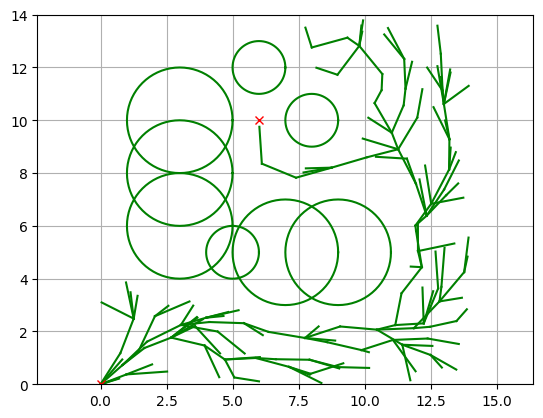

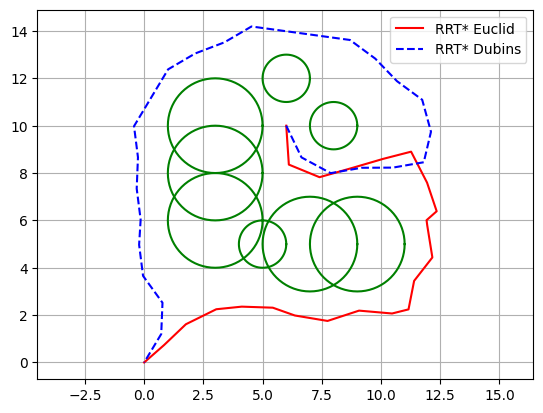

In [22]:
"""

Path planning Sample Code with RRT*

author: Atsushi Sakai(@Atsushi_twi)

"""

import math
import sys
import matplotlib.pyplot as plt
import pathlib

show_animation = True

random.seed(1982132681)
np.random.seed(1982132681)

class RRTStar(RRT):
    """
    Class for RRT Star planning
    """

    class Node(RRT.Node):
        def __init__(self, x, y, yaw=None):
            super().__init__(x, y, yaw=yaw)
            self.cost = 0.0

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 # 2025143782 Dabeen-Yun
                 expand_dis=1.5,
                 path_resolution=0.2,
                 goal_sample_rate=5,
                 max_iter=1500,
                 connect_circle_dist=50.0,
                 search_until_max_iter=False,
                 robot_radius=0.0,
                 use_dubins=False,
                 min_turning_radius=1.0
                 ):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]

        """
        super().__init__(start, goal, obstacle_list, rand_area, expand_dis,
                         path_resolution, goal_sample_rate, max_iter,
                         robot_radius=robot_radius,
                         # 2025143782 Dabeen-Yun
                         use_dubins=use_dubins,
                         min_turning_radius=min_turning_radius)
        self.connect_circle_dist = connect_circle_dist
        self.goal_node = self.Node(goal[0], goal[1])
        self.search_until_max_iter = search_until_max_iter
        self.node_list = []

    def planning(self, animation=True):
        """
        rrt star path planning

        animation: flag for animation on or off .
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            # print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)
            new_node = self.steer(self.node_list[nearest_ind], rnd,
                                  self.expand_dis)
            near_node = self.node_list[nearest_ind]
            new_node.cost = near_node.cost + \
                math.hypot(new_node.x-near_node.x,
                           new_node.y-near_node.y)

            if self.check_collision(
                    new_node, self.obstacle_list, self.robot_radius):
                near_inds = self.find_near_nodes(new_node)
                node_with_updated_parent = self.choose_parent(
                    new_node, near_inds)
                if node_with_updated_parent:
                    self.rewire(node_with_updated_parent, near_inds)
                    self.node_list.append(node_with_updated_parent)
                else:
                    self.node_list.append(new_node)

            if animation:
                self.draw_graph(rnd)

            if ((not self.search_until_max_iter)
                    and new_node):  # if reaches goal
                last_index = self.search_best_goal_node()
                if last_index is not None:
                    return self.generate_final_course(last_index)

        print("reached max iteration")

        last_index = self.search_best_goal_node()
        if last_index is not None:
            return self.generate_final_course(last_index)

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and th tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:
            near_node = self.node_list[i]
            t_node = self.steer(near_node, new_node)
            if t_node and self.check_collision(
                    t_node, self.obstacle_list, self.robot_radius):
                costs.append(self.calc_new_cost(near_node, new_node))
                # 2025143782 Dabeen-Yun
                # costs.append(near_node.cost + self.edge_length(t_node))
            else:
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]
        new_node = self.steer(self.node_list[min_ind], new_node)
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):
        dist_to_goal_list = [
            self.calc_dist_to_goal(n.x, n.y) for n in self.node_list
        ]
        goal_inds = [
            dist_to_goal_list.index(i) for i in dist_to_goal_list
            if i <= self.expand_dis
        ]

        safe_goal_inds = []
        for goal_ind in goal_inds:
            t_node = self.steer(self.node_list[goal_ind], self.goal_node)
            if self.check_collision(
                    t_node, self.obstacle_list, self.robot_radius):
                safe_goal_inds.append(goal_ind)

        if not safe_goal_inds:
            return None

        # 2025143782 Dabeen-Yun
        # safe_goal_costs = []
        # for i in safe_goal_inds:
        #     edge = self.steer(self.node_list[i], self.goal_node, self.expand_dis)
        #     edge_cost = self.edge_length(edge) if edge else float("inf")
        #     safe_goal_costs.append(self.node_list[i].cost + edge_cost)
        safe_goal_costs = [self.node_list[i].cost +
                           self.calc_dist_to_goal(self.node_list[i].x, self.node_list[i].y)
                           for i in safe_goal_inds]

        min_cost = min(safe_goal_costs)
        for i, cost in zip(safe_goal_inds, safe_goal_costs):
            if cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """
        1) defines a ball centered on new_node
        2) Returns all nodes of the three that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * math.sqrt(math.log(nnode) / nnode)
        # if expand_dist exists, search vertices in a range no more than
        # expand_dist
        if hasattr(self, 'expand_dis'):
            r = min(r, self.expand_dis)
        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(
                edge_node, self.obstacle_list, self.robot_radius)
            improved_cost = near_node.cost > edge_node.cost

            if no_collision and improved_cost:
                for node in self.node_list:
                    if node.parent == self.node_list[i]:
                        node.parent = edge_node
                self.node_list[i] = edge_node
                self.propagate_cost_to_leaves(self.node_list[i])
    # 2025143782 Dabeen-Yun
    def edge_length(node):
        if node is None or len(node.path_x) < 2:
            return float("inf")
        dist = 0.0
        for k in range(1, len(node.path_x)):
            dx = node.path_x[k] - node.path_x[k-1]
            dy = node.path_y[k] - node.path_y[k-1]
            dist += math.hypot(dx, dy)
        return dist

    def calc_new_cost(self, from_node, to_node):
        # 2025143782 Dabeen-Yun
        # t = self.steer(from_node, to_node, self.expand_dis)
        # if (t is None) or (not self.check_collision(t, self.obstacle_list, self.robot_radius)):
        #     return float("inf")
        # return from_node.cost + self.edge_length(t)

        d, _ = self.calc_distance_and_angle(from_node, to_node)
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)


def main():
    # print("Start " + __file__)

    # ====Search Path with RRT====
    obstacle_list = [
        (5, 5, 1),
        (3, 6, 2),
        (3, 8, 2),
        (3, 10, 2),
        (7, 5, 2),
        (9, 5, 2),
        (8, 10, 1),
        (6, 12, 1),
    ]  # [x,y,size(radius)]

    # 2025143782 Dabeen-Yun
    # Euclidean RRT*
    rrt_star_e = RRTStar(
        start=[0, 0], goal=[6, 10],
        rand_area=[0, 14],
        obstacle_list=obstacle_list,
        robot_radius=0.8,
        use_dubins=False
    )
    path_e = rrt_star_e.planning(animation=False)

    # Dubins RRT*
    rrt_star_d = RRTStar(
        start=[0, 0], goal=[6, 10],
        rand_area=[0, 14],
        obstacle_list=obstacle_list,
        robot_radius=0.8,
        use_dubins=True,
        min_turning_radius=1.2
    )
    path_d = rrt_star_d.planning(animation=False)

    print("[RRT* Euclid]  success:", path_e is not None)
    print("[RRT* Dubins]  success:", path_d is not None)

    # Draw final path
    if show_animation:
        rrt_star_e.draw_graph()
        for (ox, oy, size) in obstacle_list:
            rrt_star_e.plot_circle(ox, oy, size)
        if path_e:
            plt.plot([x for (x, y) in path_e], [y for (x, y) in path_e], '-r', label='RRT* Euclid')
        if path_d:
            plt.plot([x for (x, y) in path_d], [y for (x, y) in path_d], '--b', label='RRT* Dubins')
        plt.legend(); plt.axis('equal'); plt.grid(True); plt.show();

if __name__ == '__main__':
    main()
